# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video. 


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn.functional as F

from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

from torch import nn
import math

from torch.optim import Adam

In [65]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    #grayScaleTransform = transforms.Grayscale()
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(groundTruthData):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
        plt.title(img[1])
        #plt.imshow(grayScaleTransform(img[0]),cmap='gray')

groundTruthData = torchvision.datasets.StanfordCars(root="F:\\2D_Imaging_UH3_Proposal", download=False)
#data = torchvision.datasets.StanfordCars(root=".", download=True)

In [62]:
print(type(groundTruthData))

<class 'torchvision.datasets.stanford_cars.StanfordCars'>


In [63]:
print(type(groundTruthData[0]))

<class 'tuple'>


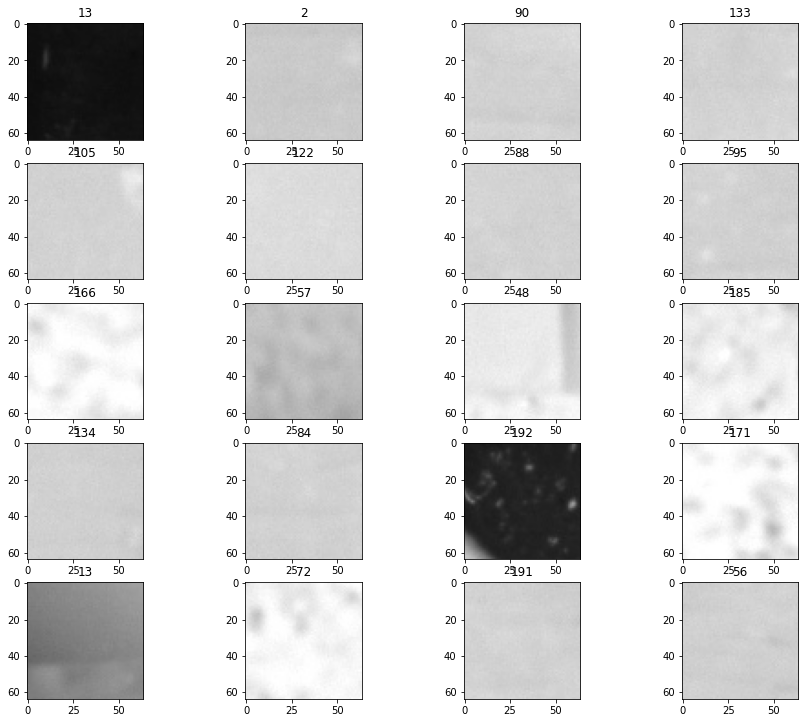

In [68]:
show_images(groundTruthData)

In [15]:
data = torchvision.datasets.StanfordCars(root="F:\\2D_Imaging_UH3_Proposal", download=False)
T=next(iter(data))

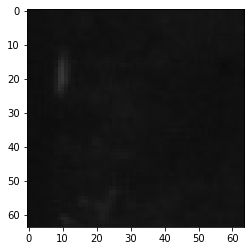

In [16]:
plt.imshow(T[0])
plt.show()

In [17]:
img, label=data[7]

In [18]:
print(label)

95


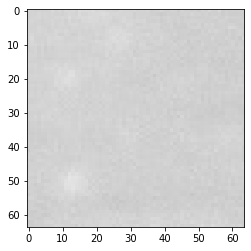

In [19]:
plt.imshow(img)
plt.show()

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [20]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [21]:

# Define beta schedule
T = 10
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [53]:
IMG_SIZE = 64
BATCH_SIZE = 64

def load_transformed_dataset(address="F:\\2D_Imaging_UH3_Proposal"):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]

    ]
    data_transform = transforms.Compose(data_transforms)     #unsqueeze(0) #Dara

    train = torchvision.datasets.StanfordCars(root=address, download=False, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=address, download=False, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()

    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image),cmap='gray')

#data = load_transformed_dataset("F:\\2D_Imaging_UH3_Proposal")
data = load_transformed_dataset(.)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

SyntaxError: invalid syntax (4128828902.py, line 36)

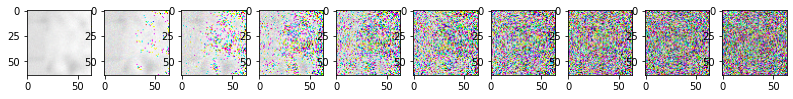

In [23]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]    # torch.Size([64, 3, 64, 64])

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)   # t:  tensor([8])
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

In [24]:
image = next(iter(dataloader))[0]

In [16]:
idx=8
print('idx: ',idx)
t = torch.Tensor([idx]).type(torch.int64)
print('t: ',t)
x_0=image
noise = torch.randn_like(x_0)
print('dimension of image or X_0: ',x_0.shape)
print('dimension of noise: ',noise.shape)
sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
print('sqrt_alphas_cumprod: ',sqrt_alphas_cumprod)
print('sqrt_alphas_cumprod_t: ',sqrt_alphas_cumprod_t)
print('sqrt_alphas_cumprod_t.shape: ',sqrt_alphas_cumprod_t.shape)

idx:  8
t:  tensor([8])
dimension of image or X_0:  torch.Size([64, 3, 64, 64])
dimension of noise:  torch.Size([64, 3, 64, 64])
sqrt_alphas_cumprod:  tensor([0.9999, 0.9988, 0.9965, 0.9932, 0.9887, 0.9832, 0.9766, 0.9690, 0.9603,
        0.9507])
sqrt_alphas_cumprod_t:  tensor([[[[0.9603]]]])
sqrt_alphas_cumprod_t.shape:  torch.Size([1, 1, 1, 1])


In [17]:
batch_size = t.shape[0]
print(batch_size)
out = sqrt_alphas_cumprod.gather(-1, t.cpu())
print(out)
sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
print(sqrt_one_minus_alphas_cumprod)
print(sqrt_one_minus_alphas_cumprod_t)
device="cpu"
image_=sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
print(image.shape)

1
tensor([0.9603])
tensor([0.0100, 0.0491, 0.0832, 0.1167, 0.1498, 0.1826, 0.2151, 0.2472, 0.2790,
        0.3103])
tensor([[[[0.2790]]]])
torch.Size([64, 3, 64, 64])


In [18]:
  sdfsd
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
        #transforms.Grayscale() #Dara
    ])

IndentationError: unexpected indent (3599399233.py, line 2)

In [27]:
image_ToPILImage = transforms.Compose([transforms.ToPILImage()])
image_ToPILImage_=image_ToPILImage(image[0, :, :, :]) # pil does not transform 4D images.
print(np.shape(image_ToPILImage_))
print(type(image_ToPILImage_))

(64, 64, 3)
<class 'PIL.Image.Image'>


In [29]:
print(image.shape)

torch.Size([64, 3, 64, 64])


In [32]:
image_ToPILImage = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])

image_ToPILImage_=image_ToPILImage(image[0, :, :, :]) # pil does not transform 4D images.
print(np.shape(image_ToPILImage_))
print(type(image_ToPILImage_))

(64, 64, 3)
<class 'PIL.Image.Image'>


In [33]:
image_ToPILImage = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8))
    ])

image_ToPILImage_=image_ToPILImage(image[0, :, :, :]) # pil does not transform 4D images.
print(np.shape(image_ToPILImage_))
print(type(image_ToPILImage_))

(64, 64, 3)
<class 'numpy.ndarray'>


In [45]:
TT=image[0, :, :, :]
print(TT.shape)
print(TT.max)
print(torch.max(TT))
print(torch.min(TT))`

torch.Size([3, 64, 64])
<built-in method max of Tensor object at 0x00000192DAAD6C20>
tensor(0.9373)
tensor(0.3098)


In [44]:
image_ToPILImage = transforms.Compose([
        transforms.Lambda(lambda t: t.numpy())
    ])

image_ToPILImage_=image_ToPILImage(image[0, :, :, :]) # pil does not transform 4D images.
print(np.shape(image_ToPILImage_))
print(type(image_ToPILImage_))
print(np.max(image_ToPILImage_))
print(np.min(image_ToPILImage_))

(3, 64, 64)
<class 'numpy.ndarray'>
0.9372549
0.30980396


In [46]:
from torchvision import utils

In [51]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i].numpy() + grid_border_size)

        plt.title('Batch from dataloader')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 2 <class 'torch.Tensor'> torch.Size([4, 3, 64, 64]) <class 'torch.Tensor'> torch.Size([4]) tensor([79, 40, 34, 69])
1 2 <class 'torch.Tensor'> torch.Size([4, 3, 64, 64]) <class 'torch.Tensor'> torch.Size([4]) tensor([115,  84,  28, 182])
2 2 <class 'torch.Tensor'> torch.Size([4, 3, 64, 64]) <class 'torch.Tensor'> torch.Size([4]) tensor([ 12,  63, 148,  59])
3 2 <class 'torch.Tensor'> torch.Size([4, 3, 64, 64]) <class 'torch.Tensor'> torch.Size([4]) tensor([163, 186,  57,  15])
4 2 <class 'torch.Tensor'> torch.Size([4, 3, 64, 64]) <class 'torch.Tensor'> torch.Size([4]) tensor([58, 91, 24, 89])
5 2 <class 'torch.Tensor'> torch.Size([4, 3, 64, 64]) <class 'torch.Tensor'> torch.Size([4]) tensor([184, 172,  66,  71])


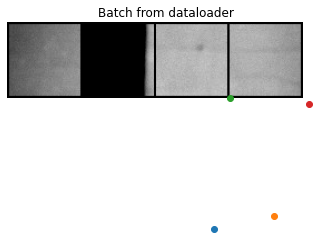

In [52]:
BATCH_SIZE=4
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched), type(sample_batched[0]),sample_batched[0].size(),
          type(sample_batched[1]),sample_batched[1].size(),sample_batched[1])
    
    # observe 4th batch and stop.
    if i_batch == 5:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, 
                padding_mode='zeros', device=None, dtype=None)

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        out_channels=3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_channels, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    numberOfChannels=3 # Dara
    img = torch.randn((1, numberOfChannels, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.0001) #Dara Changed learning rate
epochs = 80 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In Table 2, we show the sample quality effects of reverse process parameterizations and training
objectives (Section 3.2). We find that the baseline option of predicting µ˜ works well only when
trained on the true variational bound instead of unweighted mean squared error, a simplified objective
akin to Eq. (14). We also see that learning reverse process variances (by incorporating a parameterized
diagonal Σθ(xt) into the variational bound) leads to unstable training and poorer sample quality
compared to fixed variances. Predicting , as we proposed, performs approximately as well as
predicting µ˜ when trained on the variational bound with fixed variances, but much better when trained
with our simplified objective.


iffusion models scale down the data with each forward process step (by a √
1 − βt factor)
so that variance does not grow when adding noise, thus providing consistently scaled inputs
to the neural net reverse process. NCSN omits this scaling factor.


In [46]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

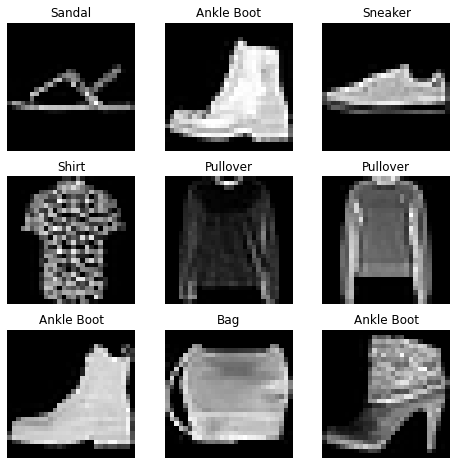

In [47]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [48]:
sample_idx = torch.randint(10, size=(1,)).item()

In [49]:
sample_idx

3

In [51]:
torch.randint(10, size=(1,1))

tensor([[3]])

In [52]:
torch.randint(10, size=(1,3))

tensor([[8, 6, 0]])

In [53]:
torch.randint(10, size=(3,1))

tensor([[7],
        [3],
        [3]])

In [54]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [63]:
img, label = next(iter(train_dataloader))

In [60]:
label

tensor([2, 4, 7, 2, 2, 2, 2, 2, 4, 9, 0, 5, 2, 3, 4, 5, 1, 4, 5, 4, 8, 5, 7, 9,
        0, 5, 3, 9, 5, 4, 5, 6, 2, 9, 3, 4, 6, 0, 8, 7, 1, 5, 3, 4, 5, 7, 8, 5,
        9, 4, 7, 0, 7, 2, 3, 6, 0, 9, 3, 0, 0, 8, 8, 6])

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


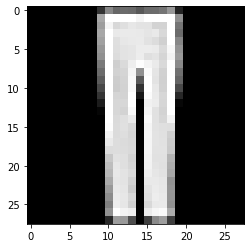

Label: 1


In [56]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [64]:
print(64*64)

4096


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


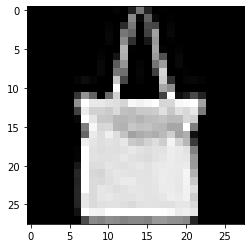

Label: 8


In [65]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [66]:
print(len(train_labels))

64


In [67]:
type(train_labels)

torch.Tensor

In [68]:
print(train_labels)

tensor([8, 3, 4, 1, 4, 3, 9, 5, 1, 6, 6, 8, 0, 0, 2, 9, 1, 6, 9, 3, 2, 2, 5, 8,
        0, 9, 3, 9, 2, 4, 9, 8, 7, 5, 4, 2, 3, 9, 0, 5, 4, 7, 9, 6, 6, 6, 5, 1,
        6, 4, 7, 7, 6, 7, 8, 2, 7, 3, 8, 7, 1, 2, 0, 1])


In [69]:
# Define beta schedule
T = 10
betas = linear_beta_schedule(timesteps=T)

In [70]:
print(betas)

tensor([1.0000e-04, 2.3111e-03, 4.5222e-03, 6.7333e-03, 8.9444e-03, 1.1156e-02,
        1.3367e-02, 1.5578e-02, 1.7789e-02, 2.0000e-02])


In [71]:
alphas = 1. - betas
print(alphas)

tensor([0.9999, 0.9977, 0.9955, 0.9933, 0.9911, 0.9888, 0.9866, 0.9844, 0.9822,
        0.9800])


In [72]:
alphas_cumprod = torch.cumprod(alphas, axis=0)
print(alphas_cumprod)

tensor([0.9999, 0.9976, 0.9931, 0.9864, 0.9776, 0.9667, 0.9537, 0.9389, 0.9222,
        0.9037])


In [73]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
print(alphas_cumprod_prev)

tensor([1.0000, 0.9999, 0.9976, 0.9931, 0.9864, 0.9776, 0.9667, 0.9537, 0.9389,
        0.9222])


In [74]:
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
print(sqrt_recip_alphas)

tensor([1.0000, 1.0012, 1.0023, 1.0034, 1.0045, 1.0056, 1.0068, 1.0079, 1.0090,
        1.0102])


In [75]:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
print(sqrt_alphas_cumprod)

tensor([0.9999, 0.9988, 0.9965, 0.9932, 0.9887, 0.9832, 0.9766, 0.9690, 0.9603,
        0.9507])


In [76]:
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
print(sqrt_one_minus_alphas_cumprod)

tensor([0.0100, 0.0491, 0.0832, 0.1167, 0.1498, 0.1826, 0.2151, 0.2472, 0.2790,
        0.3103])


In [77]:
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
posterior_variance

tensor([0.0000e+00, 9.5877e-05, 1.5750e-03, 3.4249e-03, 5.4264e-03, 7.5063e-03,
        9.6330e-03, 1.1791e-02, 1.3971e-02, 1.6168e-02])

In [135]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_list = [name for name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, name))]
        self.img_list = [name for name in self.img_list if name[-3:]=="jpg"]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = read_image(img_path)
        label = self.img_list[idx][:-4]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label# Simulate forward diffusion

In [72]:
import os
img_dir="F:\\2D_Imaging_UH3_Proposal\\stanford_cars\\cars_train"
img_list=[name for name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, name))]

In [71]:
print(list_[:4])

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg']


In [73]:
idx=10

In [75]:
img_path = os.path.join(img_dir,img_list[idx])
img_path

'F:\\2D_Imaging_UH3_Proposal\\stanford_cars\\cars_train\\00011.jpg'

In [77]:
img_list[idx][:-4]

'00011'

In [112]:
daraData=CustomImageDataset("F:\\2D_Imaging_UH3_Proposal\\stanford_cars\\cars_train",transform=T.ToPILImage())

In [136]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    #grayScaleTransform = transforms.Grayscale()
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(datset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
        plt.title(img[1])
        #plt.imshow(grayScaleTransform(img[0]),cmap='gray')
daraData=CustomImageDataset("F:\\2D_Imaging_UH3_Proposal\\stanford_cars\\cars_train",transform=T.ToPILImage())

00001


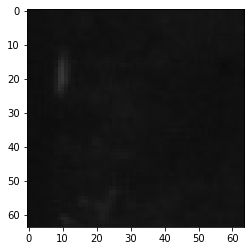

In [137]:
image, label=daraData[0]
print(label)
plt.imshow(image)
plt.show()

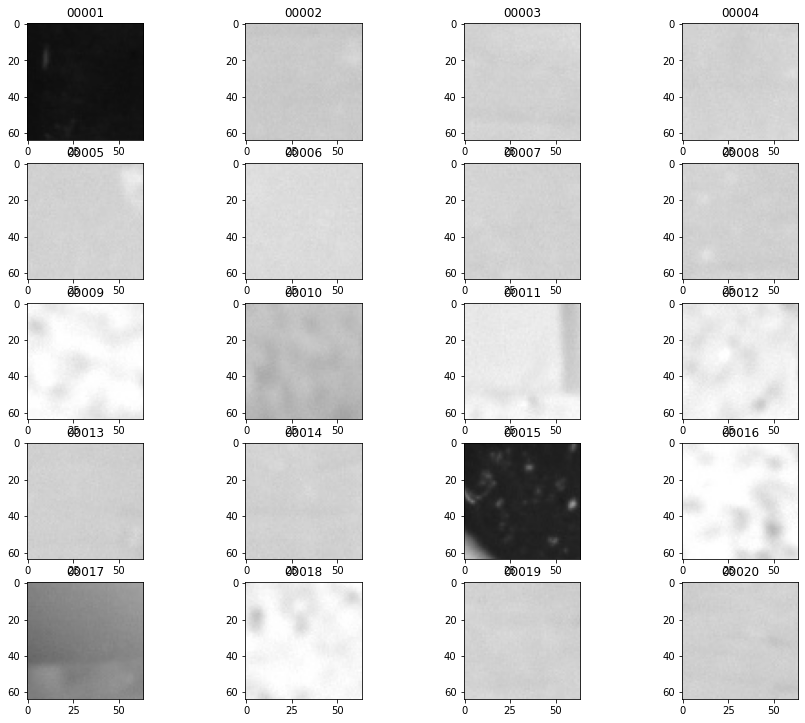

In [138]:
show_images(daraData)

In [115]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    #grayScaleTransform = transforms.Grayscale()
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(groundTruthData):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
        plt.title(img[1])
        #plt.imshow(grayScaleTransform(img[0]),cmap='gray')

groundTruthData = torchvision.datasets.StanfordCars(root="F:\\2D_Imaging_UH3_Proposal", download=False)
#data = torchvision.datasets.StanfordCars(root=".", download=True)

13
<PIL.Image.Image image mode=RGB size=64x64 at 0x19C74D206A0>


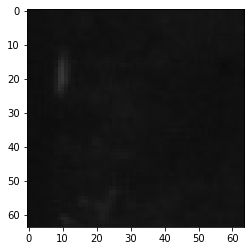

In [116]:
image,label=groundTruthData[0]
print(label)
print(image)
plt.imshow(image)
plt.show()

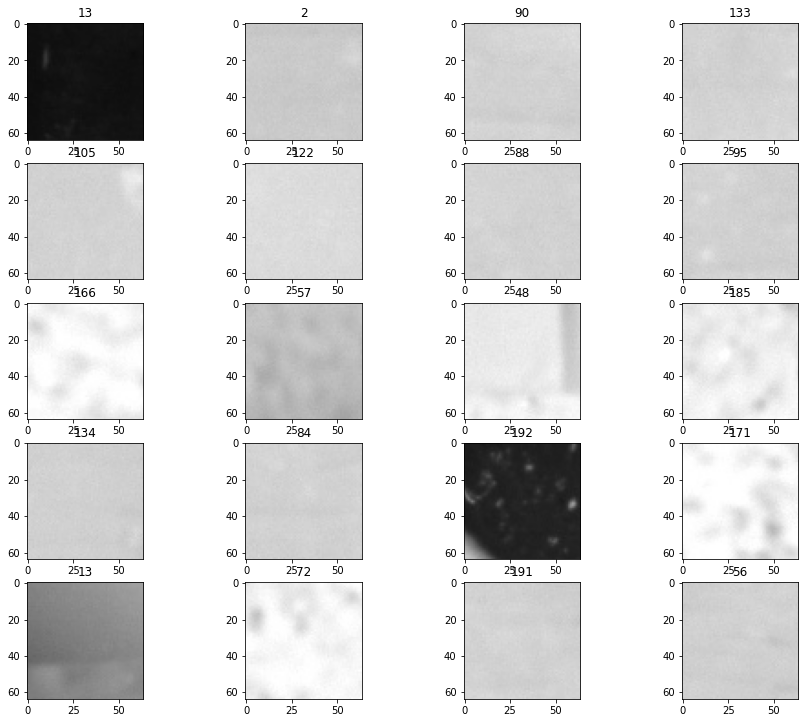

In [90]:
show_images(groundTruthData)

In [119]:
address="F:\\2D_Imaging_UH3_Proposal"
data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]

    ]
data_transform = transforms.Compose(data_transforms)     #unsqueeze(0) #Dara

train = torchvision.datasets.StanfordCars(root=address, download=False, 
                                         transform=data_transform)

test = torchvision.datasets.StanfordCars(root=address, download=False, 
                                         transform=data_transform, split='test')
concatenated=torch.utils.data.ConcatDataset([train, test])

In [120]:
print(concatenated)

In [124]:
print(len(concatenated))

16185


In [125]:
list_=np.arange(10)

In [132]:
for number in list_:
    if number!=11:
        print(number)

0
1
2
3
4
5
6
7
8
9


In [144]:
daraData=CustomImageDataset("F:\\2D_Imaging_UH3_Proposal\\stanford_cars\\cars_train")
dataloaderDara = DataLoader(daraData, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [145]:
image = next(iter(dataloaderDara))[0]

In [146]:
print(image.shape)

torch.Size([4, 3, 64, 64])


RuntimeError: "normal_kernel_cpu" not implemented for 'Byte'

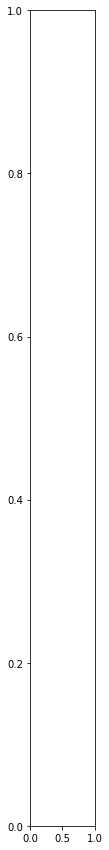

In [148]:
# Simulate forward diffusion
image = next(iter(dataloaderDara))[0]    # torch.Size([64, 3, 64, 64])
T=200

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)   # t:  tensor([8])
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

In [2]:
for i in range(3):
    for j in range(3):
        print(i,j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


In [3]:
import matplotlib.pyplot as plt
fig=plt.figure()

<Figure size 432x288 with 0 Axes>

TypeError: cannot unpack non-iterable AxesSubplot object

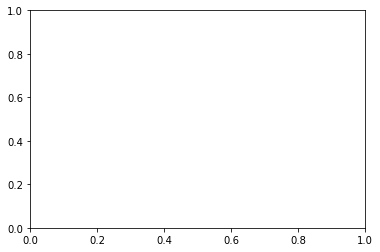

In [8]:
fig , ax= plt.subplot()